# Model Training (coupler_NCap_cap_matrix)

## Configuration

In [1]:
# The parameter file is where the hyperparameters are set. 
# It's reccomended to look at that file first, its interesting and you can set stuff there

from parameters import *

## Library

In [2]:
# Disable some console warnings so you can be free of them printing. 
# Comment the next two lines if you are a professional and like looking at warnings.
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf 

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, LeakyReLU
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from keras_tuner import HyperModel, RandomSearch
from tensorflow.keras.models import load_model
from pathlib import Path

import os, gc, joblib
import numpy as np
import pandas as pd

In [3]:
seed = 0

# Input seed value. If this value is the same, the random number generator 
# will generate the same set of random values every time. We like reproducibility:)
np.random.seed(seed)

# Set the seed value for reproducibility in tensorflow
tf.random.set_seed(seed)

## Check GPU

In [4]:
from tensorflow.python.client import device_lib

# Look at what you are working with. If you dont have a nice GPU I highly reccomend finding one
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16061251335026650175
xla_global_id: -1
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16587413015652329601
physical_device_desc: "device: XLA_CPU device"
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 37913034752
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3027810255946316749
physical_device_desc: "device: 0, name: NVIDIA A100 80GB PCIe MIG 4g.40gb, pci bus id: 0000:00:10.0, compute capability: 8.0"
xla_global_id: 416903419
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9771322642761545389
physical_device_desc: "device: XLA_GPU device"
xla_global_id: -1
]


## Dataset

### Load

In [5]:
# Load all of the nice data you saved from the previous notebook, or downloaded from the drive

if DATA_AUGMENTATION:
    if 'Try Both' not in ENCODING_TYPE:
        encoding = ENCODING_TYPE.replace(' ','_')
        X_train = np.load('{}/npy/x_train_{}_encoding_augmented.npy'.format(DATA_DIR, encoding), allow_pickle=True)
        X_val = np.load('{}/npy/x_val_{}_encoding_augmented.npy'.format(DATA_DIR, encoding), allow_pickle=True)
        X_test = np.load('{}/npy/x_test_{}_encoding_augmented.npy'.format(DATA_DIR, encoding), allow_pickle=True)
        y_train = np.load('{}/npy/y_train_{}_encoding_augmented.npy'.format(DATA_DIR, encoding), allow_pickle=True)
        y_val = np.load('{}/npy/y_val_{}_encoding_augmented.npy'.format(DATA_DIR, encoding), allow_pickle=True)
        y_test = np.load('{}/npy/y_test_{}_encoding_augmented.npy'.format(DATA_DIR, encoding), allow_pickle=True)
    
    elif 'Try Both' in ENCODING_TYPE:
        X_train_one_hot_encoding = np.load('{}/npy/x_train_one_hot_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        X_val_one_hot_encoding = np.load('{}/npy/x_val_one_hot_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        X_test_one_hot_encoding = np.load('{}/npy/x_test_one_hot_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        y_train_one_hot_encoding = np.load('{}/npy/y_train_one_hot_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        y_val_one_hot_encoding = np.load('{}/npy/y_val_one_hot_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        y_test_one_hot_encoding = np.load('{}/npy/y_test_one_hot_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)

        X_train_linear_encoding = np.load('{}/npy/x_train_linear_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        X_val_linear_encoding = np.load('{}/npy/x_val_linear_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        X_test_linear_encoding = np.load('{}/npy/x_test_linear_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        y_train_linear_encoding = np.load('{}/npy/y_train_linear_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        y_val_linear_encoding = np.load('{}/npy/y_val_linear_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        y_test_linear_encoding = np.load('{}/npy/y_test_linear_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)

else:
    if 'Try Both' not in ENCODING_TYPE:
        X_train = np.load('{}/npy/x_train_{}_encoding.npy'.format(DATA_DIR, encoding), allow_pickle=True)
        X_val = np.load('{}/npy/x_val_{}_encoding.npy'.format(DATA_DIR, encoding), allow_pickle=True)
        X_test = np.load('{}/npy/x_test_{}_encoding.npy'.format(DATA_DIR, encoding), allow_pickle=True)
        y_train = np.load('{}/npy/y_train_{}_encoding.npy'.format(DATA_DIR, encoding), allow_pickle=True)
        y_val = np.load('{}/npy/y_val_{}_encoding.npy'.format(DATA_DIR, encoding), allow_pickle=True)
        y_test = np.load('{}/npy/y_test_{}_encoding.npy'.format(DATA_DIR, encoding), allow_pickle=True)
    
    elif 'Try Both' in ENCODING_TYPE:
        X_train_one_hot_encoding = np.load('{}/npy/x_train_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        X_val_one_hot_encoding = np.load('{}/npy/x_val_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        X_test_one_hot_encoding = np.load('{}/npy/x_test_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        y_train_one_hot_encoding = np.load('{}/npy/y_train_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        y_val_one_hot_encoding = np.load('{}/npy/y_val_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        y_test_one_hot_encoding = np.load('{}/npy/y_test_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)

        X_train_linear_encoding = np.load('{}/npy/x_train_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        X_val_linear_encoding = np.load('{}/npy/x_val_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        X_test_linear_encoding = np.load('{}/npy/x_test_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        y_train_linear_encoding = np.load('{}/npy/y_train_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        y_val_linear_encoding = np.load('{}/npy/y_val_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        y_test_linear_encoding = np.load('{}/npy/y_test_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)


### Visualize

In [6]:
# Look at the shapes of training and test sets incase you want to orient yourself

if 'Try Both' not in ENCODING_TYPE:
    print('X_train.shape: ', X_train.shape)
    print('X_val.shape: ', X_val.shape)
    print('y_train.shape: ', y_train.shape)
    print('y_val.shape: ', y_val.shape)
    print('y_train[0]: ', y_train[0])
else:
    print('X_train_linear_encoding.shape: ', X_train_linear_encoding.shape)
    print('X_val_linear_encoding.shape: ', X_val_linear_encoding.shape)
    print('y_train_linear_encoding.shape: ', y_train_linear_encoding.shape)
    print('y_val_linear_encoding.shape: ', y_val_linear_encoding.shape)
    print('y_train_linear_encoding[0]: ', y_train_linear_encoding[0])

    print('X_train_one_hot_encoding.shape: ', X_train_one_hot_encoding.shape)
    print('X_val_one_hot_encoding.shape: ', X_val_one_hot_encoding.shape)
    print('y_train_one_hot_encoding.shape: ', y_train_one_hot_encoding.shape)
    print('y_val_one_hot_encoding.shape: ', y_val_one_hot_encoding.shape)
    print('y_train_one_hot_encoding[0]: ', y_train_one_hot_encoding[0])

X_train.shape:  (301, 6)
X_val.shape:  (64, 6)
y_train.shape:  (301, 12)
y_val.shape:  (64, 12)
y_train[0]:  [0.         0.         0.         0.         0.         0.8
 0.         0.         0.44444444 0.         0.         0.        ]


In [7]:
if 'Try Both' not in ENCODING_TYPE:
    display(X_train) #can check this in previous script as well after loading to make sure it matches
else:
    display(X_train_one_hot_encoding)
    display(X_train_linear_encoding)

array([[0.25127446, 0.20992091, 0.33539481, 0.30081633, 0.36236553,
        0.36319847],
       [0.40338031, 0.33586484, 0.52535925, 0.4487671 , 0.52526255,
        0.53231277],
       [0.09561798, 0.01222453, 0.26989726, 0.02343084, 0.03190241,
        0.09262483],
       ...,
       [0.46445341, 0.37218769, 0.62157739, 0.55351521, 0.67505178,
        0.66310282],
       [0.19765952, 0.19513876, 0.21539692, 0.19535602, 0.19389822,
        0.19768766],
       [0.39144854, 0.43210422, 0.31307081, 0.38361896, 0.34813125,
        0.34186674]])

In [8]:
# Look at how it was split and decide if you like the split

if 'Try Both' not in ENCODING_TYPE:
    total = len(X_train) + len(X_test) + len(X_val)
    print('---------------------------------------')  
    print('Train set shape x:                {}, {:.2f}%'.format(len(X_train), (len(X_train)*100.)/total))
    print('Validation set shape x:           {}, {:.2f}%'.format(len(X_train), (len(X_val)*100.)/total))
    print('Test set shape x:                 {}, {:.2f}%'.format(len(X_test), (len(X_test)*100.)/total))
    print('---------------------------------------')

    total = len(y_train) + len(y_test) + len(y_val)
    print('---------------------------------------')  
    print('Train set shape y:                {}, {:.2f}%'.format(len(y_train), (len(y_train)*100.)/total))
    print('Validation set shape y:           {}, {:.2f}%'.format(len(y_val), (len(y_val)*100.)/total))
    print('Test set shape y:                 {}, {:.2f}%'.format(len(y_test), (len(y_test)*100.)/total))
    print('---------------------------------------')
else:
    total = len(X_train_one_hot_encoding) + len(X_test_one_hot_encoding) + len(X_val_one_hot_encoding)
    print('---------------------------------------')  
    print('Train set shape x one_hot_encoding:      {}, {:.2f}%'.format(len(X_train_one_hot_encoding), (len(X_train_one_hot_encoding)*100.)/total))
    print('Validation set shape x one_hot_encoding: {}, {:.2f}%'.format(len(X_train_one_hot_encoding), (len(X_val_one_hot_encoding)*100.)/total))
    print('Test set shape x one_hot_encoding:       {}, {:.2f}%'.format(len(X_test_one_hot_encoding), (len(X_test_one_hot_encoding)*100.)/total))
    print('---------------------------------------')

    total = len(y_train_one_hot_encoding) + len(y_test_one_hot_encoding) + len(y_val_one_hot_encoding)
    print('---------------------------------------')  
    print('Train set shape y one_hot_encoding:         {}, {:.2f}%'.format(len(y_train_one_hot_encoding), (len(y_train_one_hot_encoding)*100.)/total))
    print('Validation set shape y one_hot_encoding:    {}, {:.2f}%'.format(len(y_val_one_hot_encoding), (len(y_val_one_hot_encoding)*100.)/total))
    print('Test set shape y one_hot_encoding:          {}, {:.2f}%'.format(len(y_test_one_hot_encoding), (len(y_test_one_hot_encoding)*100.)/total))


    total = len(X_train_linear_encoding) + len(X_test_linear_encoding) + len(X_val_linear_encoding)
    print('---------------------------------------')  
    print('Train set shape x linear_encoding:      {}, {:.2f}%'.format(len(X_train_linear_encoding), (len(X_train_linear_encoding)*100.)/total))
    print('Validation set shape x linear_encoding: {}, {:.2f}%'.format(len(X_train_linear_encoding), (len(X_val_linear_encoding)*100.)/total))
    print('Test set shape x linear_encoding:       {}, {:.2f}%'.format(len(X_test_linear_encoding), (len(X_test_linear_encoding)*100.)/total))
    print('---------------------------------------')

    total = len(y_train_linear_encoding) + len(y_test_linear_encoding) + len(y_val_linear_encoding)
    print('---------------------------------------')  
    print('Train set shape y linear_encoding:         {}, {:.2f}%'.format(len(y_train_linear_encoding), (len(y_train_linear_encoding)*100.)/total))
    print('Validation set shape y linear_encoding:    {}, {:.2f}%'.format(len(y_val_linear_encoding), (len(y_val_linear_encoding)*100.)/total))
    print('Test set shape y linear_encoding:          {}, {:.2f}%'.format(len(y_test_linear_encoding), (len(y_test_linear_encoding)*100.)/total))

---------------------------------------
Train set shape x:                301, 70.00%
Validation set shape x:           301, 14.88%
Test set shape x:                 65, 15.12%
---------------------------------------
---------------------------------------
Train set shape y:                301, 70.00%
Validation set shape y:           64, 14.88%
Test set shape y:                 65, 15.12%
---------------------------------------


In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

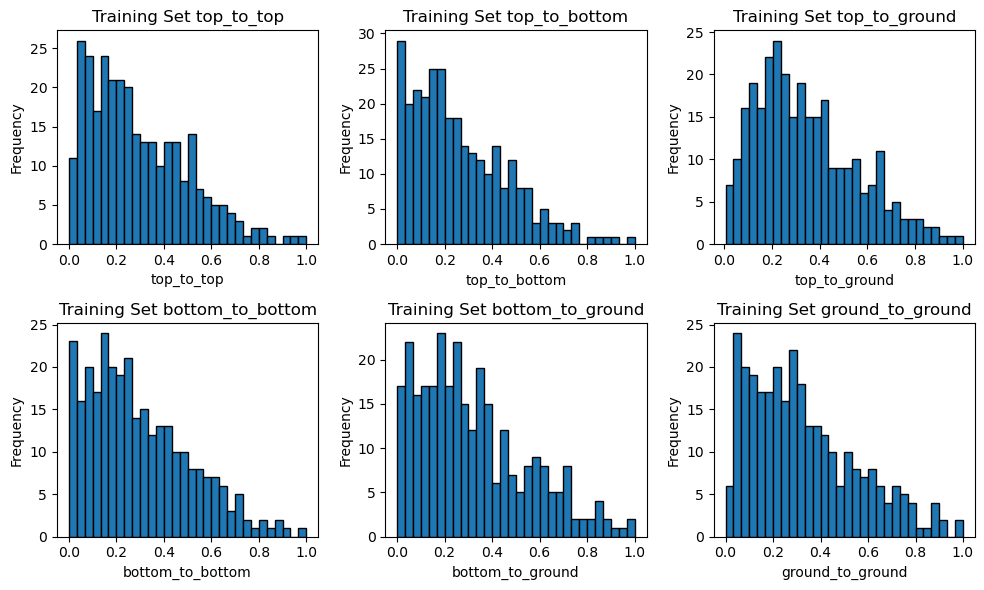

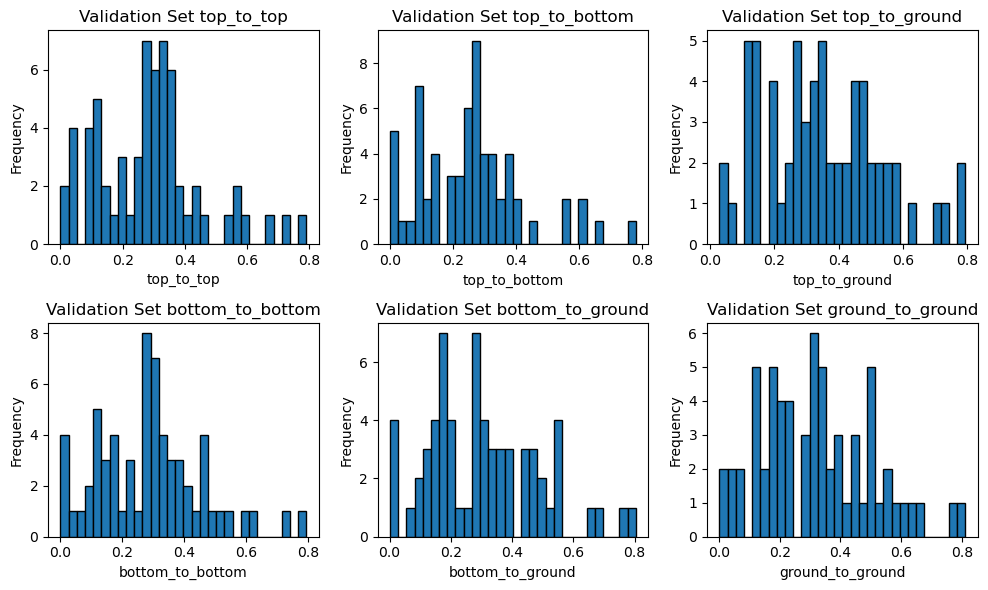

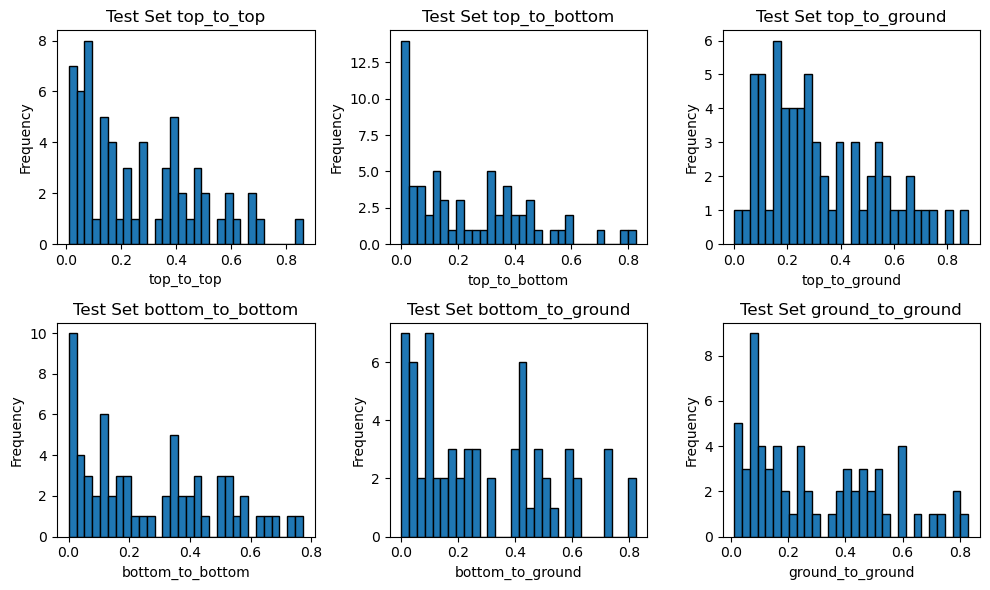

In [10]:
# Bin the data and look at how its distributed, probably the more random/spread out the better 
# for training, but this will improve as the database fills out

if 'Try Both' not in ENCODING_TYPE:
    #--------------------Training Set---------------------
    save_encoding = ENCODING_TYPE.replace(' ','_')
    
    num_cols = X_train.shape[1]
    num_rows = math.ceil(num_cols / 3)
    
    fig, axes = plt.subplots(num_rows, 3, figsize=(10, 3 * num_rows))
    axes = axes.ravel()
    
    with open('X_names', 'r') as f:
        column_labels = f.read().splitlines()
    
    
    for i in range(num_cols):
        axes[i].hist(X_train[:, i], bins=30, edgecolor='black')
        axes[i].set_title(f'Training Set {column_labels[i]}')
        axes[i].set_xlabel(f'{column_labels[i]}')
        axes[i].set_ylabel('Frequency')
    
    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.savefig(f'plots/training_set_data_distribution{save_encoding}.pdf')
    plt.show()

    #--------------------Validation Set---------------------
    num_cols = X_val.shape[1]
    num_rows = math.ceil(num_cols / 3)
    
    fig, axes = plt.subplots(num_rows, 3, figsize=(10, 3 * num_rows))
    axes = axes.ravel()
    
    with open('X_names', 'r') as f:
        column_labels = f.read().splitlines()
    
    
    for i in range(num_cols):
        axes[i].hist(X_val[:, i], bins=30, edgecolor='black')
        axes[i].set_title(f'Validation Set {column_labels[i]}')
        axes[i].set_xlabel(f'{column_labels[i]}')
        axes[i].set_ylabel('Frequency')
    
    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.savefig(f'plots/validation_set_data_distribution{save_encoding}.pdf')
    plt.show()
    
    #--------------------Test Set---------------------
    num_cols = X_test.shape[1]
    num_rows = math.ceil(num_cols / 3)
    
    fig, axes = plt.subplots(num_rows, 3, figsize=(10, 3 * num_rows))
    axes = axes.ravel()
    
    with open('X_names', 'r') as f:
        column_labels = f.read().splitlines()
    
    
    for i in range(num_cols):
        axes[i].hist(X_test[:, i], bins=30, edgecolor='black')
        axes[i].set_title(f'Test Set {column_labels[i]}')
        axes[i].set_xlabel(f'{column_labels[i]}')
        axes[i].set_ylabel('Frequency')
    
    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.savefig(f'plots/test_set_data_distribution{save_encoding}.pdf')
    plt.show()
    
else: #just plot linear encoding for now to not get plot overwhelm
    #--------------------Training Set---------------------
    num_cols = X_train_linear_encoding.shape[1]
    num_rows = math.ceil(num_cols / 3)
    
    fig, axes = plt.subplots(num_rows, 3, figsize=(10, 3 * num_rows))
    axes = axes.ravel()
    
    with open('X_names', 'r') as f:
        column_labels = f.read().splitlines()
    
    
    for i in range(num_cols):
        axes[i].hist(X_train_linear_encoding[:, i], bins=30, edgecolor='black')
        axes[i].set_title(f'Training Set {column_labels[i]}')
        axes[i].set_xlabel(f'{column_labels[i]}')
        axes[i].set_ylabel('Frequency')
    
    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.savefig('plots/training_set_data_distribution_linear_encoding.pdf')
    plt.show()

    #--------------------Validation Set---------------------
    num_cols = X_val_linear_encoding.shape[1]
    num_rows = math.ceil(num_cols / 3)
    
    fig, axes = plt.subplots(num_rows, 3, figsize=(10, 3 * num_rows))
    axes = axes.ravel()
    
    with open('X_names', 'r') as f:
        column_labels = f.read().splitlines()
    
    
    for i in range(num_cols):
        axes[i].hist(X_val_linear_encoding[:, i], bins=30, edgecolor='black')
        axes[i].set_title(f'Validation Set {column_labels[i]}')
        axes[i].set_xlabel(f'{column_labels[i]}')
        axes[i].set_ylabel('Frequency')
    
    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.savefig('plots/validation_set_data_distribution_linear_encoding.pdf')
    plt.show()
    
    
    #--------------------Test Set---------------------
    num_cols = X_test_linear_encoding.shape[1]
    num_rows = math.ceil(num_cols / 3)
    
    fig, axes = plt.subplots(num_rows, 3, figsize=(10, 3 * num_rows))
    axes = axes.ravel()
    
    with open('X_names', 'r') as f:
        column_labels = f.read().splitlines()
    
    for i in range(num_cols):
        axes[i].hist(X_test_linear_encoding[:, i], bins=30, edgecolor='black')
        axes[i].set_title(f'Test Set {column_labels[i]}')
        axes[i].set_xlabel(f'{column_labels[i]}')
        axes[i].set_ylabel('Frequency')
    
    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.savefig('plots/test_set_data_distribution_linear_encoding.pdf')
    plt.show()

## MLP

### Create model

Create a classical multi-layer perceptron for regression: 602 input features, 10 targets, and a certain number of hidden layers and neurons. Taking some inspiration from [Deep learning-based I-V Global Parameter Extraction for BSIM-CMG](https://www.sciencedirect.com/science/article/pii/S003811012300179X), Solid-State Electronics, Vol. 209, November 2023.

The above publication predicted parameters for BSIM, which is a physics model for advanced transistors that is complicated and might be a similar complexity to the physics we are trying to target/map with these SC qubit hamiltonian values

Reccomended to download a third party app like "Sleep control Center" or "Amphetamine" to prevent computer from sleeping during the many hour/day long training process

### Create Model by Hand

In [11]:
if not KERAS_TUNER:
    # n output neurons for n parameters
    if 'Try Both' not in ENCODING_TYPE:
        # Multilayer perceptron (MLP) with 2 input features. MLP is having neurons that adjust rules based on how accurate they can guess things
        model_shape = f'mlp_{len(X_test[0])}_'
        
        # Define the number on neurons in the inner layer (in parameter file)
        model_shape += '_'.join(str(l) for l in NEURONS_PER_LAYER)
    
        print(len(y_train[0]))
        model_shape += f'_{len(y_train[0])}'
    else:
        # Multilayer perceptron (MLP) with 2 input features. MLP is having neurons that adjust rules based on how accurate they can guess things
        model_shape_one_hot_encoding = f'mlp_{len(X_test_one_hot_encoding[0])}_'
        model_shape_linear_encoding = f'mlp_{len(X_test_one_hot_encoding[0])}_'
        
        # Define the number on neurons in the inner layer (in parameter file)
        model_shape_one_hot_encoding += '_'.join(str(l) for l in NEURONS_PER_LAYER)
        model_shape_linear_encoding += '_'.join(str(l) for l in NEURONS_PER_LAYER)
    
        print('one hot: ',len(y_train_one_hot_encoding[0]))
        model_shape_one_hot_encoding += f'_{len(y_train_one_hot_encoding[0])}'
        print('linear: ',len(y_train_linear_encoding[0]))
        model_shape_linear_encoding += f'_{len(y_train_linear_encoding[0])}'


12


In [12]:
if not KERAS_TUNER:
    if 'Try Both' not in ENCODING_TYPE:
        # Initialize a sequential model, which lets us build a linear stack of layers
        model = Sequential()
        
        # Add an input layer to the model. This layer defines the shape of the input data (2 features per sample), sets dimensions of following layers
        model.add(Input(shape=(len(X_test[0]),), name='input1'))
        
        # Iterate over the configuration of neurons for each hidden layer specified in NEURONS_PER_LAYER
        for i, n in enumerate(NEURONS_PER_LAYER):
            # Add a fully connected (dense) hidden layer with spec ified number of neurons
            # The LeCun uniform initializer is used when initializing weights, this makes the model more stable
            # L2 regularization is used in each layer to penalizing large weights, which prevents overfitting
            model.add(Dense(n, name='fc{}'.format(i), kernel_initializer='lecun_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
        
            # Apply a Leaky ReLU activation function to the outputs of the dense layer
            # This introduces non-linearities, allowing the network to learn complex functions
            # Leaky ReLU is chosen over standard ReLU to help mitigate the "dying ReLU" problem:
            #     - This problem is when neurons using the ReLU activation function output zero for all inputs and stop learning
            #     - Can be mitigated by using variations like Leaky ReLU or proper initialization
            model.add(LeakyReLU(negative_slope=0.01, name='leaky_relu{}'.format(i)))
            
            # Add a dropout layer to reduce overfitting -- randomly drops a set fraction (like 30%) of outputs from the layer
            model.add(Dropout(rate=TRAIN_DROPOUT_RATE, name='dropout{}'.format(i)))
        
        # Add the output layer consisting of # neurons, corresponding to the # target variables we aim to predict.
        # The same LeCun uniform initializer is used to ensure consistency and stability at the output layer as well.
        model.add(Dense(len(y_train[0]), activation='linear', name='fc_output', kernel_initializer='lecun_uniform'))
    
    else:
        model_one_hot_encoding = Sequential()
        model_one_hot_encoding.add(Input(shape=(len(X_test_one_hot_encoding[0]),), name='input1'))
        for i, n in enumerate(NEURONS_PER_LAYER):
            model_one_hot_encoding.add(Dense(n, name='fc{}'.format(i), kernel_initializer='lecun_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
            model_one_hot_encoding.add(LeakyReLU(negative_slope=0.01, name='leaky_relu{}'.format(i)))
            model_one_hot_encoding.add(Dropout(rate=TRAIN_DROPOUT_RATE, name='dropout{}'.format(i)))
        model_one_hot_encoding.add(Dense(len(y_train_one_hot_encoding[0]), activation='linear', name='fc_output', kernel_initializer='lecun_uniform'))
    
        model_linear_encoding = Sequential()
        model_linear_encoding.add(Input(shape=(len(X_test_linear_encoding[0]),), name='input1'))
        for i, n in enumerate(NEURONS_PER_LAYER):
            model_linear_encoding.add(Dense(n, name='fc{}'.format(i), kernel_initializer='lecun_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
            model_linear_encoding.add(LeakyReLU(negative_slope=0.01, name='leaky_relu{}'.format(i)))
            model_linear_encoding.add(Dropout(rate=TRAIN_DROPOUT_RATE, name='dropout{}'.format(i)))
        model_linear_encoding.add(Dense(len(y_train_linear_encoding[0]), activation='linear', name='fc_output', kernel_initializer='lecun_uniform'))

In [13]:
if not KERAS_TUNER:
    # The exponential decay learning rate schedule gradually reduces the learning rate, fine-tuning the learning process for better convergence
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=LR_INITIAL,  
        decay_steps=LR_DECAY_STEPS,        
        decay_rate=LR_DECAY_RATE,          
        staircase=LR_STAIRCASE             
    )
    
    if 'Try Both' not in ENCODING_TYPE:
        # Set model to minimize loss specified by TRAIN_LOSS, and also to report the loss during training
        model.compile(
            optimizer=tf.optimizers.Adam(learning_rate=lr_schedule),  
            loss=TRAIN_LOSS,                                         
            metrics=[TRAIN_LOSS]                                     
        )
    else:
        # Set model to minimize loss specified by TRAIN_LOSS, and also to report the loss during training
        model_linear_encoding.compile(
            optimizer=tf.optimizers.Adam(learning_rate=lr_schedule),  
            loss=TRAIN_LOSS,                                         
            metrics=[TRAIN_LOSS]                                     
        )
        model_one_hot_encoding.compile(
            optimizer=tf.optimizers.Adam(learning_rate=lr_schedule),  
            loss=TRAIN_LOSS,                                         
            metrics=[TRAIN_LOSS]                                     
        )

In [14]:
if not KERAS_TUNER:
    !mkdir -p model
    if 'Try Both' not in ENCODING_TYPE:
        best_model_file = 'model/{}_best_model.keras'.format(model_shape)
        last_model_file = 'model/{}_last_model.keras'.format(model_shape)
    else:
        best_model_file_one_hot_encoding = 'model/{}_best_model_one_hot_encoding.keras'.format(model_shape_one_hot_encoding)
        last_model_file_one_hot_encoding = 'model/{}_last_model_one_hot_encoding.keras'.format(model_shape_one_hot_encoding)
    
        best_model_file_linear_encoding = 'model/{}_best_model_linear_encoding.keras'.format(model_shape_linear_encoding)
        last_model_file_linear_encoding = 'model/{}_last_model_linear_encoding.keras'.format(model_shape_linear_encoding)

Enable training (`train_and_save`) to overwrite the model file.

In [15]:
train_and_save = True

We use Adam optimizer, minimize the Mean Squared Logarithmic Error, and early stop.

#### Training

In [16]:
from IPython.display import clear_output
# Set up monitors and plots for later tracking purposes

if not KERAS_TUNER:
    class TrainingPlot(tf.keras.callbacks.Callback):
         
        # This function is called when the training begins
        def on_train_begin(self, logs={}):
            # Initialize the lists for holding the logs, losses 
            self.losses = []
            self.val_losses = []
            self.logs = []
        
        # This function is called at the end of each epoch
        def on_epoch_end(self, epoch, logs={}):
            
            # Append the logs, losses  to the lists
            self.logs.append(logs)
            self.losses.append(logs.get('loss'))
            self.val_losses.append(logs.get('val_loss'))
            
            # Before plotting ensure at least 2 epochs have passed
            if len(self.losses) > 1:
                
                # Clear the previous plot
                clear_output(wait=True)
                N = np.arange(0, len(self.losses))
                
                # Plot train loss, train acc, val loss and val acc against epochs passed
                plt.figure()
                plt.plot(N, self.losses, label = "train_loss")
                plt.plot(N, self.val_losses, label = "val_loss")
                plt.title("Training Loss [Epoch {}]".format(epoch))
                plt.xlabel("Epoch #")
                plt.ylabel("Loss/Accuracy")
                plt.legend()
                plt.show()
           

class LearningRateMonitor(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.learning_rates = []

    #we have to do some checking for versions here or else we will get an Adam error when using this monitor
    def _current_lr(self, optimizer):
        # look and see if you get "lr" ir "learning_rate" depending on the version
        lr = getattr(optimizer, "lr", None) or getattr(optimizer, "learning_rate", None)

        # if this is a shecdule then evaluate it at current iteration step
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            return float(lr(optimizer.iterations).numpy())

        # if not a schedule, its a scalar/variable/tensor
        return float(tf.keras.backend.get_value(lr))

    def on_epoch_end(self, epoch, logs=None):
        try:
            lr_val = self._current_lr(self.model.optimizer)
        except Exception:
            # for anything else fallback
            lr_val = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        self.learning_rates.append(lr_val)


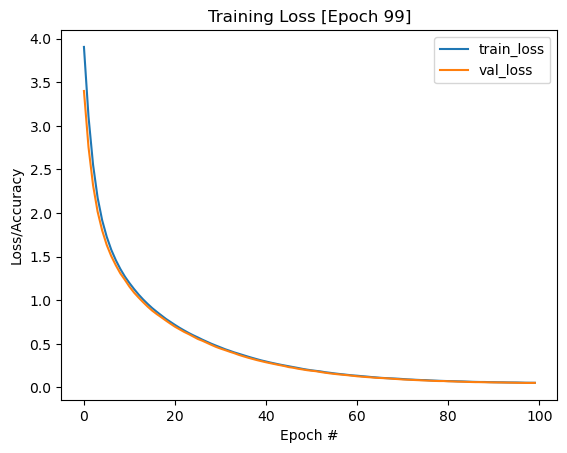

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0539 - mean_squared_error: 0.0331 - val_loss: 0.0526 - val_mean_squared_error: 0.0322
CPU times: user 1min 9s, sys: 1min 35s, total: 2min 45s
Wall time: 1min 8s


In [17]:
%%time

# Train the model
history = None  
if not KERAS_TUNER:
    if train_and_save: 
        # Set up early stopping to prevent overfitting by halting training when validation loss stops improving
        early_stopping = EarlyStopping(
            monitor='val_loss',                      # Monitor validation loss for stopping criteria 
            mode='min',                              # Stop when the monitored quantity has stopped decreasing
            patience=TRAIN_EARLY_STOPPING_PATIENCE,  # Number of epochs to wait after last improvement
            verbose=1                                # Enable logging when early stopping happens
        )
    
        # Train the model on the training data and validate on a portion of it
        if 'Try Both' not in ENCODING_TYPE:
            plot_callback = TrainingPlot()      # Plot training progress
            lr_monitor = LearningRateMonitor()  # Watch learning rate changes
            
            # Set up model checkpointing to save the model at its best validation loss:
            model_checkpoint = ModelCheckpoint(
                filepath=best_model_file,          
                monitor='val_loss',            # Save the model based on validation loss improvement
                mode='min',                    # Favor lower validation loss values for saving (minimize)
                save_best_only=True,           # Save only when validation loss improves
                verbose=0                      # No logging for model saving
            )
    
            history = model.fit(
                np.asarray(X_train),  
                np.asarray(y_train),      
                epochs=100,                   
                batch_size=TRAIN_BATCH_SIZE,  
                validation_data=(np.asarray(X_val), np.asarray(y_val)),  
                callbacks=[early_stopping, model_checkpoint, plot_callback, lr_monitor],  
                verbose=1  # Enable logging of the training process.
            )
            
            model.save(last_model_file)  # Save the final model when done training!
        
        else:
            #-----------------------------------------linear--------------------------------------------
            plot_callback_linear_encoding = TrainingPlot()      # Plot training progress
            lr_monitor_linear_encoding = LearningRateMonitor()  # Watch learning rate changes
            
            # Set up model checkpointing to save the model at its best validation loss:
            model_checkpoint_linear_encoding = ModelCheckpoint(
                filepath=best_model_file_linear_encoding,          
                monitor='val_loss',            # Save the model based on validation loss improvement
                mode='min',                    # Favor lower validation loss values for saving (minimize)
                save_best_only=True,           # Save only when validation loss improves
                verbose=0                      # No logging for model saving
            )
            
            history_linear_encoding = model_linear_encoding.fit(
                np.asarray(X_train_linear_encoding),  
                np.asarray(y_train_linear_encoding),      
                epochs=100,                   
                batch_size=TRAIN_BATCH_SIZE,  
                validation_data=(np.asarray(X_val_linear_encoding), np.asarray(y_val_linear_encoding)), 
                callbacks=[early_stopping, model_checkpoint_linear_encoding, plot_callback_linear_encoding, lr_monitor_linear_encoding],  
                verbose=1  # Enable logging of the training process.
            )
            
            model_linear_encoding.save(last_model_file_linear_encoding)  # Save the final model when done training!
            
            #-----------------------------------------one hot--------------------------------------------
            plot_callback_one_hot_encoding = TrainingPlot()      # Plot training progress
            lr_monitor_one_hot_encoding = LearningRateMonitor()  # Watch learning rate changes
            
            # Set up model checkpointing to save the model at its best validation loss:
            model_checkpoint_one_hot_encoding = ModelCheckpoint(
                filepath=best_model_file_one_hot_encoding,          
                monitor='val_loss',            # Save the model based on validation loss improvement
                mode='min',                    # Favor lower validation loss values for saving (minimize)
                save_best_only=True,           # Save only when validation loss improves
                verbose=0                      # No logging for model saving
            )
            
            history_one_hot_encoding = model_one_hot_encoding.fit(
                np.asarray(X_train_one_hot_encoding),  
                np.asarray(y_train_one_hot_encoding),      
                epochs=100,                   
                batch_size=TRAIN_BATCH_SIZE,  
                validation_data=(np.asarray(X_val_one_hot_encoding), np.asarray(y_val_one_hot_encoding)), 
                callbacks=[early_stopping, model_checkpoint_one_hot_encoding, plot_callback_one_hot_encoding, lr_monitor_one_hot_encoding],  
                verbose=1  # Enable logging of the training process.
            )
            
            model_one_hot_encoding.save(last_model_file_one_hot_encoding)  # Save the final model when done training!


Load the saved best model and use it from now on.

In [18]:
if not KERAS_TUNER:
    if 'Try Both' not in ENCODING_TYPE:
        model = load_model(best_model_file, custom_objects={})
    else:
        model_one_hot_encoding = load_model(best_model_file_one_hot_encoding, custom_objects={})
        model_linear_encoding = load_model(best_model_file_linear_encoding, custom_objects={})

### Keras Tuner to Find Best Hyperparameters and Model

Run this if you want to use keras tuner to make the model rather than doing it by hand

In [19]:
if KERAS_TUNER:
    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import Dense, Input, Dropout
    from tensorflow.keras.regularizers import l2
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
    from keras_tuner import HyperModel, RandomSearch
    from tensorflow.keras.models import load_model

In [20]:
if KERAS_TUNER:
    if 'Try Both' not in ENCODING_TYPE:
        def build_hypermodel(hp):
            # Hyperparameters to tune
            neurons_per_layer = [hp.Int(f'neurons_{i}', min_value=100, max_value=5000, step=100) for i in range(4)]
            dropout_rate = hp.Float('dropout_rate', TRAIN_DROPOUT_RATE, 0.5, step=0.1)
            
            # Create Model in the same way that we do by hand
            model = Sequential()
            model.add(Input(shape=(len(X_test[0]),), name='input1'))
        
            for i, n in enumerate(neurons_per_layer):
                model.add(Dense(n, name=f'fc{i}', kernel_initializer='lecun_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
                model.add(LeakyReLU(negative_slope=0.01, name=f'leaky_relu{i}'))
                model.add(Dropout(rate=dropout_rate, name=f'dropout{i}'))
        
            model.add(Dense(len(y_train[0]), name='output', kernel_initializer='lecun_uniform'))
        
            # Learning rate configuration
            lr_initial = hp.Float('learning_rate', 1e-6, 5e-3, sampling='LOG', default=0.0001)
            lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=lr_initial,
                decay_steps=LR_DECAY_STEPS,
                decay_rate=LR_DECAY_RATE,
                staircase=LR_STAIRCASE
            )
        
            model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr_schedule), 
                          loss='mean_squared_error',
                          metrics=['mean_squared_error'])
            return model
    else:
        def build_hypermodel_one_hot_encoding(hp):
             # Hyperparameters to tune
            neurons_per_layer = [hp.Int(f'neurons_{i}', min_value=100, max_value=5000, step=100) for i in range(4)]
            dropout_rate = hp.Float('dropout_rate', TRAIN_DROPOUT_RATE, 0.5, step=0.1)
            
            #----------------------------------------------one hot-------------------------------------------
            # Create Model in the same way that we do by hand
            model_one_hot_encoding = Sequential()
            model_one_hot_encoding.add(Input(shape=(len(X_test_one_hot_encoding[0]),), name='input1'))
        
            for i, n in enumerate(neurons_per_layer):
                model_one_hot_encoding.add(Dense(n, name=f'fc{i}', kernel_initializer='lecun_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
                model_one_hot_encoding.add(LeakyReLU(negative_slope=0.01, name=f'leaky_relu{i}'))
                model_one_hot_encoding.add(Dropout(rate=dropout_rate, name=f'dropout{i}'))
        
            model_one_hot_encoding.add(Dense(len(y_train_one_hot_encoding[0]), name='output', kernel_initializer='lecun_uniform'))
            
            # Learning rate configuration
            lr_initial = hp.Float('learning_rate', 1e-6, 5e-3, sampling='LOG', default=0.0001)
            lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=lr_initial,
                decay_steps=LR_DECAY_STEPS,
                decay_rate=LR_DECAY_RATE,
                staircase=LR_STAIRCASE
            )

            optimizer = tf.optimizers.Adam(learning_rate=lr_schedule)
            model_one_hot_encoding.compile(optimizer=optimizer, 
                          loss='mean_squared_error',
                          metrics=['mean_squared_error'])
            return model_one_hot_encoding

        def build_hypermodel_linear_encoding(hp):
            # Hyperparameters to tune
            neurons_per_layer = [hp.Int(f'neurons_{i}', min_value=100, max_value=5000, step=100) for i in range(4)]
            dropout_rate = hp.Float('dropout_rate', TRAIN_DROPOUT_RATE, 0.5, step=0.1)
            
            #----------------------------------------------linear------------------------------------------- 
            # Create Model in the same way that we do by hand
            model_linear_encoding = Sequential()
            model_linear_encoding.add(Input(shape=(len(X_test_linear_encoding[0]),), name='input1'))
        
            for i, n in enumerate(neurons_per_layer):
                model_linear_encoding.add(Dense(n, name=f'fc{i}', kernel_initializer='lecun_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
                model_linear_encoding.add(LeakyReLU(negative_slope=0.01, name=f'leaky_relu{i}'))
                model_linear_encoding.add(Dropout(rate=dropout_rate, name=f'dropout{i}'))
        
            model_linear_encoding.add(Dense(len(y_train_linear_encoding[0]), name='output', kernel_initializer='lecun_uniform'))
            #----------------------------------------------continue-------------------------------------------

            # Learning rate configuration
            lr_initial = hp.Float('learning_rate', 1e-6, 5e-3, sampling='LOG', default=0.0001)
            lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=lr_initial,
                decay_steps=LR_DECAY_STEPS,
                decay_rate=LR_DECAY_RATE,
                staircase=LR_STAIRCASE
            )
            optimizer = tf.optimizers.Adam(learning_rate=lr_schedule)
            model_linear_encoding.compile(optimizer=optimizer, 
                          loss='mean_squared_error',
                          metrics=['mean_squared_error'])
            return model_linear_encoding

In [21]:
if 'Try Both' not in ENCODING_TYPE:
    if KERAS_TUNER:
        # Start tuning
        tuner = RandomSearch(
            build_hypermodel,
            objective='val_loss',
            max_trials=KERAS_TUNER_TRIALS,
            executions_per_trial=1,
            directory=KERAS_DIR + '/hyper_tuning',
            project_name='mlp_tuning'
        )
else:
    if KERAS_TUNER:
        # Start tuning linear encoding
        tuner_linear_encoding = RandomSearch(
            build_hypermodel_linear_encoding,
            objective='val_loss',
            max_trials=KERAS_TUNER_TRIALS,
            executions_per_trial=1,
            directory=KERAS_DIR + '/hyper_tuning_linear_encoding',
            project_name='mlp_tuning_linear_encoding'
        )

        # Start tuning one hot encoding
        tuner_one_hot_encoding = RandomSearch(
            build_hypermodel_one_hot_encoding,
            objective='val_loss',
            max_trials=KERAS_TUNER_TRIALS,
            executions_per_trial=1,
            directory=KERAS_DIR + '/hyper_tuning_one_hot_encoding',
            project_name='mlp_tuning_one_hot_encoding'
        )
    

In [22]:
if KERAS_TUNER:
    # Setup Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=TRAIN_EARLY_STOPPING_PATIENCE,
        verbose=1
    )

In [23]:
if KERAS_TUNER:
    if 'Try Both' not in ENCODING_TYPE:
        # Perform hyperparameter tuning
        tuner.search(np.asarray(X_train), 
                     np.asarray(y_train), 
                     epochs=50, 
                     batch_size=TRAIN_BATCH_SIZE, 
                     validation_data=(np.asarray(X_val), np.asarray(y_val)),
                     callbacks=[early_stopping], 
                     verbose=1)
    else:
        # Perform hyperparameter tuning
        tuner_one_hot_encoding.search(np.asarray(X_train_one_hot_encoding), 
                     np.asarray(y_train_one_hot_encoding), 
                     epochs=50, 
                     batch_size=TRAIN_BATCH_SIZE, 
                     validation_data=(np.asarray(X_val_one_hot_encoding), np.asarray(y_val_one_hot_encoding)),
                     callbacks=[early_stopping], 
                     verbose=1)

        tuner_linear_encoding.search(np.asarray(X_train_linear_encoding), 
                     np.asarray(y_train_linear_encoding), 
                     epochs=50, 
                     batch_size=TRAIN_BATCH_SIZE, 
                     validation_data=(np.asarray(X_val_linear_encoding), np.asarray(y_val_linear_encoding)),
                     callbacks=[early_stopping], 
                     verbose=1)

In [24]:
if KERAS_TUNER:
    if 'Try Both' not in ENCODING_TYPE:
        os.makedirs('model', exist_ok=True)
        best_model_file= f'model/best_keras_model_{encoding}_encoding.keras'

        best_model = tuner.get_best_models(1)[0]
        best_model.save(best_model_file)

        #gpu is thowing errors, lets try to clear its memory
        tf.keras.backend.clear_session()
        gc.collect()
        
        #lets not compile to help with the memory bug
        with tf.device('/CPU:0'):
            loaded_model = load_model(best_model_file, compile=False)
    else:
        os.makedirs('model', exist_ok=True)
        best_model_file_linear = 'model/best_keras_model_linear_encoding.keras'
        best_model_file_onehot = 'model/best_keras_model_one_hot_encoding.keras'
        
        best_linear_model = tuner_linear_encoding.get_best_models(1)[0]
        best_onehot_model = tuner_one_hot_encoding.get_best_models(1)[0]
        
        best_linear_model.save(best_model_file_linear)
        best_onehot_model.save(best_model_file_onehot)
        
        #gpu is thowing errors, lets try to clear its memory
        tf.keras.backend.clear_session()
        gc.collect()
        
        #lets not compile to help with the memory bug
        with tf.device('/CPU:0'):
            loaded_linear_model = load_model(best_model_file_linear, compile=False)
            loaded_onehot_model = load_model(best_model_file_onehot, compile=False)


### View the model

In [25]:
if KERAS_TUNER:
    if 'Try Both' not in ENCODING_TYPE:
        best_model.summary()
    else:
        best_onehot_model.summary()
        best_linear_model.summary()
        
if not KERAS_TUNER:
    if 'Try Both' not in ENCODING_TYPE:
        print("\n---- Model Summary ----")
        model.summary()
    else:
        print("\n---- Linear Encoding Model Summary ----")
        model_linear_encoding.summary()
        
        print("\n---- One-Hot Encoding Model Summary ----")
        model_one_hot_encoding.summary()


---- Model Summary ----


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fc0 (Dense)                     │ (None, 1600)           │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu0 (LeakyReLU)         │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout0 (Dropout)              │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 1300)           │     2,081,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu1 (LeakyReLU)         │ (None, 1300)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 1300)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 700)            │       910,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu2 (LeakyReLU)         │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 600)            │       420,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu3 (LeakyReLU)         │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_output (Dense)               │ (None, 12)             │         7,212 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,293,041 (39.26 MB)

 Trainable params: 3,431,012 (13.09 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,862,029 (26.18 MB)

### Evaluation

Although we may plot and print many metrics, we focus only on **Mean Squared Error (MSE).**

Plot training history.

In [26]:
#%matplotlib ipympl
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

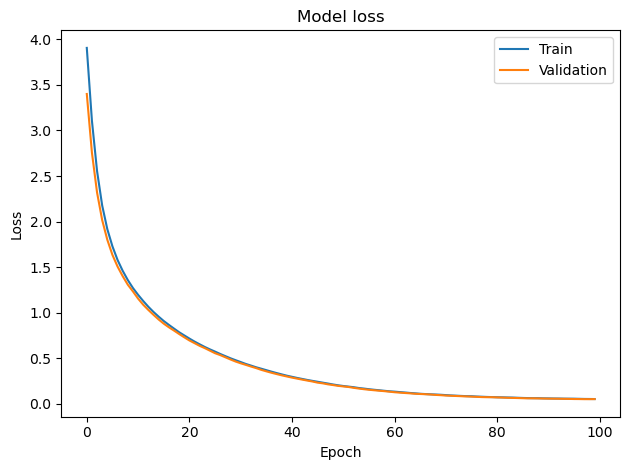

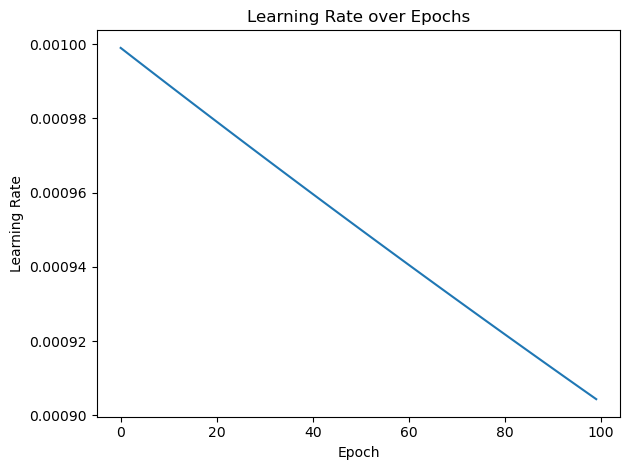

In [27]:
if 'Try Both' not in ENCODING_TYPE:
    if KERAS_TUNER:
        # now both searches should have completed, so lets get the best hyperparams 
        # and retrain with history saved so we can look at it
        best_hp  = tuner.get_best_hyperparameters(1)[0]
        
        # make the models again using the best hyperparams
        model    = tuner.hypermodel.build(best_hp)

        lr_monitor = LearningRateMonitor()  # make learning rate monitor
        
        # retrain with history so we can plot it
        history = model.fit(
            np.asarray(X_train),
            np.asarray(y_train),
            epochs=50,
            batch_size=TRAIN_BATCH_SIZE,
            validation_data=(np.asarray(X_val), np.asarray(y_val)),
            callbacks=[early_stopping, lr_monitor],
            verbose=1
        )
        
        # keep getting a memory allocation error on EAF so lets free everything after the first 
        # model fit, before moving to the next one
        
        del model
        tf.keras.backend.clear_session()
        gc.collect()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.tight_layout()
    plt.savefig(f'plots/{encoding}_history.pdf')
    plt.show()

    plt.plot(lr_monitor.learning_rates)
    plt.title("Learning Rate over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.tight_layout()
    plt.savefig(f'plots/{encoding}_learning_rate.pdf')
    plt.show()
else:
    if KERAS_TUNER:
        # now both searches should have completed, so lets get the best hyperparams 
        # and retrain with history saved so we can look at it
        best_hp_linear  = tuner_linear_encoding.get_best_hyperparameters(1)[0]
        
        # make the models again using the best hyperparams
        model_linear    = tuner_linear_encoding.hypermodel.build(best_hp_linear)

        lr_monitor_linear_encoding = LearningRateMonitor()  # make learning rate monitor
        
        # retrain with history so we can plot it
        history_linear_encoding = model_linear.fit(
            np.asarray(X_train_linear_encoding),
            np.asarray(y_train_linear_encoding),
            epochs=50,
            batch_size=TRAIN_BATCH_SIZE,
            validation_data=(np.asarray(X_val_linear_encoding), np.asarray(y_val_linear_encoding)),
            callbacks=[early_stopping, lr_monitor_linear_encoding],
            verbose=1
        )
        
        # keep getting a memory allocation error on EAF so lets free everything after the first 
        # model fit, before moving to the next one
        
        del model_linear
        tf.keras.backend.clear_session()
        gc.collect()

    plt.plot(history_linear_encoding.history['loss'])
    plt.plot(history_linear_encoding.history['val_loss'])
    plt.title('Model loss linear encoding')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.tight_layout()
    plt.savefig('plots/linear_encoding_history.pdf')
    plt.show()

    plt.plot(lr_monitor_linear_encoding.learning_rates)
    plt.title("Learning Rate over Epochs linear encoding")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.tight_layout()
    plt.savefig('plots/linear_encoding_learning_rate.pdf')
    plt.show()


In [28]:
#take a look at the loss results and save them 

# clear everything so we start with a blank slate memory wise
tf.keras.backend.clear_session()                         #clear tf backend
gc.collect()                                             #just collect stray things
tf.config.experimental.reset_memory_stats('GPU:0')       #clear gpus


def get_loss(eval_out):
    # eval_out can be float, list/tuple/ndarray, or dict
    if isinstance(eval_out, dict):
        return float(eval_out.get('loss', list(eval_out.values())[0]))
    if isinstance(eval_out, (list, tuple, np.ndarray)):
        return float(eval_out[0])
    return float(eval_out)

def mlp_signature(m, prefix="mlp"):
    #get the model input sizze first
    in_shape = m.input_shape
    if isinstance(in_shape, list):     #just get the first one
        in_shape = in_shape[0]
    dims = [d for d in in_shape[1:] if d is not None]
    input_size = int(np.prod(dims)) if dims else "None"

    # now get the dense laysers in order
    dense_units = [l.units for l in m.layers if isinstance(l, Dense)]

    parts = [prefix, str(input_size)] + [str(u) for u in dense_units]
    return "_".join(parts)

    
if 'Try Both' not in ENCODING_TYPE:
    model = load_model(best_model_file, compile=False)
    model.compile(optimizer='adam', loss=TRAIN_LOSS)
    test_loss_result = get_loss(model.evaluate(
            np.asarray(X_test),
            np.asarray(y_test)))
    test_loss_result = get_loss(test_loss_result)
    
    #save the shape for the next block so we can save it using the definition above
    model_shape = mlp_signature(model)

    print('Current loss {} encoding {}: {}'.format(encoding, TRAIN_LOSS, test_loss_result))
    
    results_df = pd.DataFrame([
        {'Encoding Type': f'{ENCODING_TYPE} Encoding', 'Train Loss Metric': TRAIN_LOSS, 'Test Loss': test_loss_result},
        ])

else:
    # we need to do some fancy allocation of recources if we are going to load both models
    # do the first on one GPU
    linear_model = load_model(best_model_file_linear, compile=False)
    linear_model.compile(optimizer='adam', loss=TRAIN_LOSS)
    test_loss_result_linear_encoding = get_loss(linear_model.evaluate(
            np.asarray(X_test_linear_encoding),
            np.asarray(y_test_linear_encoding)))
    test_loss_result_linear_encoding = get_loss(test_loss_result_linear_encoding)
    
    # now do on CPU to avoid GPU allocation
    with tf.device('/CPU:0'):
        onehot_model = load_model(best_model_file_onehot, compile=False)
        onehot_model.compile(optimizer='adam', loss=TRAIN_LOSS)
        test_loss_result_one_hot_encoding = get_loss(onehot_model.evaluate(
                np.asarray(X_test_one_hot_encoding),
                np.asarray(y_test_one_hot_encoding)))
        test_loss_result_one_hot_encoding = get_loss(test_loss_result_one_hot_encoding)

    #save the shape for the next block so we can save it using the definition above
    model_shape_one_hot_encoding = mlp_signature(onehot_model)
    model_shape_linear_encoding  = mlp_signature(linear_model)
    
    print('Current loss linear encoding {}: {}'.format(TRAIN_LOSS, test_loss_result_linear_encoding))
    print('Current loss one hot encoding {}: {}'.format(TRAIN_LOSS, test_loss_result_one_hot_encoding))
    
    results_df = pd.DataFrame([
        {'Encoding Type': 'Linear Encoding', 'Train Loss Metric': TRAIN_LOSS, 'Test Loss': test_loss_result_linear_encoding},
        {'Encoding Type': 'One Hot Encoding', 'Train Loss Metric': TRAIN_LOSS, 'Test Loss': test_loss_result_one_hot_encoding}
    ])

print(results_df.to_string(index=False))
results_df.to_csv('test_loss_results.csv', index=False)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 0.0504
Current loss one_hot encoding mean_squared_error: 0.04967968165874481
   Encoding Type  Train Loss Metric  Test Loss
one hot Encoding mean_squared_error    0.04968


Measure and print metrics.

In [29]:
#take a look at the loss results and save them 

# clear everything so we start with a blank slate memory wise
tf.keras.backend.clear_session()                         #clear tf backend
gc.collect()                                             #just collect stray things
tf.config.experimental.reset_memory_stats('GPU:0')       #clear gpus


def get_loss(eval_out):
    # eval_out can be float, list/tuple/ndarray, or dict
    if isinstance(eval_out, dict):
        return float(eval_out.get('loss', list(eval_out.values())[0]))
    if isinstance(eval_out, (list, tuple, np.ndarray)):
        return float(eval_out[0])
    return float(eval_out)

def mlp_signature(m, prefix="mlp"):
    #get the model input sizze first
    in_shape = m.input_shape
    if isinstance(in_shape, list):     #just get the first one
        in_shape = in_shape[0]
    dims = [d for d in in_shape[1:] if d is not None]
    input_size = int(np.prod(dims)) if dims else "None"

    # now get the dense laysers in order
    dense_units = [l.units for l in m.layers if isinstance(l, Dense)]

    parts = [prefix, str(input_size)] + [str(u) for u in dense_units]
    return "_".join(parts)

    
if 'Try Both' not in ENCODING_TYPE:
    model = load_model(best_model_file, compile=False)
    model.compile(optimizer='adam', loss=TRAIN_LOSS)
    test_loss_result = get_loss(model.evaluate(
            np.asarray(X_test),
            np.asarray(y_test)))
    test_loss_result = get_loss(test_loss_result)
    
    #save the shape for the next block so we can save it using the definition above
    model_shape = mlp_signature(model)

    print('Current loss {} encoding {}: {}'.format(encoding, TRAIN_LOSS, test_loss_result))
    
    results_df = pd.DataFrame([
        {'Encoding Type': f'{ENCODING_TYPE} Encoding', 'Train Loss Metric': TRAIN_LOSS, 'Test Loss': test_loss_result},
        ])

else:
    # we need to do some fancy allocation of recources if we are going to load both models
    # do the first on one GPU
    linear_model = load_model(best_model_file_linear, compile=False)
    linear_model.compile(optimizer='adam', loss=TRAIN_LOSS)
    test_loss_result_linear_encoding = get_loss(linear_model.evaluate(
            np.asarray(X_test_linear_encoding),
            np.asarray(y_test_linear_encoding)))
    test_loss_result_linear_encoding = get_loss(test_loss_result_linear_encoding)
    
    # now do on CPU to avoid GPU allocation
    with tf.device('/CPU:0'):
        onehot_model = load_model(best_model_file_onehot, compile=False)
        onehot_model.compile(optimizer='adam', loss=TRAIN_LOSS)
        test_loss_result_one_hot_encoding = get_loss(onehot_model.evaluate(
                np.asarray(X_test_one_hot_encoding),
                np.asarray(y_test_one_hot_encoding)))
        test_loss_result_one_hot_encoding = get_loss(test_loss_result_one_hot_encoding)

    #save the shape for the next block so we can save it using the definition above
    model_shape_one_hot_encoding = mlp_signature(onehot_model)
    model_shape_linear_encoding  = mlp_signature(linear_model)
    
    print('Current loss linear encoding {}: {}'.format(TRAIN_LOSS, test_loss_result_linear_encoding))
    print('Current loss one hot encoding {}: {}'.format(TRAIN_LOSS, test_loss_result_one_hot_encoding))
    
    results_df = pd.DataFrame([
        {'Encoding Type': 'Linear Encoding', 'Train Loss Metric': TRAIN_LOSS, 'Test Loss': test_loss_result_linear_encoding},
        {'Encoding Type': 'One Hot Encoding', 'Train Loss Metric': TRAIN_LOSS, 'Test Loss': test_loss_result_one_hot_encoding}
    ])

print(results_df.to_string(index=False))
results_df.to_csv('test_loss_results.csv', index=False)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 0.0504
Current loss one_hot encoding mean_squared_error: 0.04967968165874481
   Encoding Type  Train Loss Metric  Test Loss
one hot Encoding mean_squared_error    0.04968


## Compare predictions vs. test set

In [30]:
import csv
if 'Try Both' not in ENCODING_TYPE:
    csv_data = [[
        DATA_AUGMENTATION,
        model_shape,
        ENCODING_TYPE,
        test_loss_result,
        TRAIN_LOSS,
        TRAIN_DROPOUT_RATE,
        TRAIN_EARLY_STOPPING_PATIENCE,
        TRAIN_BATCH_SIZE,
        '0.15/0.15',
        LR_INITIAL,
        LR_DECAY_STEPS,
        LR_DECAY_RATE,
        LR_STAIRCASE
        ]]
    
    csv_file = 'history_losses.csv'  #this doesnt reqrite this file so you need to delete this if you want something fresh
    
    if not os.path.exists(csv_file):
        with open(csv_file, 'w') as file:
            file.write('data_augmentation,model_shape,encoding_type,test_loss,train_loss,train_dropout_rate,train_early_stop_patience,'+
                        'train_batch_size,train_val_split,lr_initial,lr_decay_step,lr_decay_rate,lr_stair_case\n')
    
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(csv_data)
    
    # Convert data to DataFrame for easier display
    df = pd.read_csv(csv_file)
    
    def color_red_column(s):
        return ['color: red' if v else '' for v in s]
    
    styled_df = df.style.apply(color_red_column, subset=['test_loss'])
    
    # Display the DataFrame as a table
    display(styled_df)
    #qgrid_widget = qgrid.show_grid(df, show_toolbar=True)

else:
    #---------------------------------------------------one hot---------------------------------------
    csv_data = [[
        DATA_AUGMENTATION,
        model_shape_one_hot_encoding,
        'One Hot',
        test_loss_result_one_hot_encoding,
        TRAIN_LOSS,
        TRAIN_DROPOUT_RATE,
        TRAIN_EARLY_STOPPING_PATIENCE,
        TRAIN_BATCH_SIZE,
        '0.15/0.15',
        LR_INITIAL,
        LR_DECAY_STEPS,
        LR_DECAY_RATE,
        LR_STAIRCASE
        ]]
    
    csv_file = 'history_losses.csv'  #this doesnt reqrite this file so you need to delete this if you want something fresh
    
    if not os.path.exists(csv_file):
        with open(csv_file, 'w') as file:
            file.write('data_augmentation,model_shape,encoding_type,test_loss,train_loss,train_dropout_rate,train_early_stop_patience,'+
                        'train_batch_size,train_val_split,lr_initial,lr_decay_step,lr_decay_rate,lr_stair_case\n')
            
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(csv_data)
    
    # Convert data to DataFrame for easier display
    df_one_hot_encoding = pd.read_csv(csv_file)
    
    def color_red_column(s):
        return ['color: red' if v else '' for v in s]
    
    styled_df_one_hot_encoding = df_one_hot_encoding.style.apply(color_red_column, subset=['test_loss'])
    #---------------------------------------------------linear---------------------------------------
    csv_data_linear_encoding = [[
        DATA_AUGMENTATION,
        model_shape_linear_encoding,
        'Linear',
        test_loss_result_linear_encoding,
        TRAIN_LOSS,
        TRAIN_DROPOUT_RATE,
        TRAIN_EARLY_STOPPING_PATIENCE,
        TRAIN_BATCH_SIZE,
        '0.15/0.15',
        LR_INITIAL,
        LR_DECAY_STEPS,
        LR_DECAY_RATE,
        LR_STAIRCASE
        ]]
    
    csv_file_linear_encoding = 'history_losses.csv'  #this doesnt reqrite this file so you need to delete this if you want something fresh
    
    with open(csv_file_linear_encoding, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(csv_data_linear_encoding)
    
    # Convert data to DataFrame for easier display
    df_linear_encoding = pd.read_csv(csv_file_linear_encoding)
    
    def color_red_column(s):
        return ['color: red' if v else '' for v in s]
    
    styled_df_linear_encoding = df_linear_encoding.style.apply(color_red_column, subset=['test_loss'])
    
    # Display the DataFrame as a table
    display(styled_df_linear_encoding)
    #qgrid_widget = qgrid.show_grid(df, show_toolbar=True)

,data_augmentation,model_shape,encoding_type,test_loss,train_loss,train_dropout_rate,train_early_stop_patience,train_batch_size,train_val_split,lr_initial,lr_decay_step,lr_decay_rate,lr_stair_case
0,True,mlp_6_1600_1300_700_600_12,One Hot,0.049943,mean_squared_error,0.400000,50,32,0.15/0.15,0.001000,100,0.990000,False
1,True,mlp_6_3700_700_200_2800_12,One Hot,0.158361,mean_squared_error,0.400000,50,32,0.15/0.15,0.001000,100,0.990000,False
2,True,mlp_6_900_1300_200_1900_12,Linear,0.047749,mean_squared_error,0.400000,50,32,0.15/0.15,0.001000,100,0.990000,False
3,True,mlp_6_3700_700_200_2800_12,One Hot,0.158361,mean_squared_error,0.400000,50,32,0.15/0.15,0.001000,100,0.990000,False
4,True,mlp_6_900_1300_200_1900_12,Linear,0.047749,mean_squared_error,0.400000,50,32,0.15/0.15,0.001000,100,0.990000,False
5,True,mlp_6_3700_700_200_2800_12,One Hot,0.158361,mean_squared_error,0.400000,50,32,0.15/0.15,0.001000,100,0.990000,False
6,True,mlp_6_900_1300_200_1900_12,Linear,0.047749,mean_squared_error,0.400000,50,32,0.15/0.15,0.001000,100,0.990000,False
7,True,mlp_6_2100_1100_200_3200_12,one hot,0.082271,mean_squared_error,0.400000,50,32,0.15/0.15,0.001000,100,0.990000,False
8,True,mlp_6_1600_1300_700_600_12,one hot,0.049680,mean_squared_error,0.400000,50,32,0.15/0.15,0.001000,100,0.990000,False


In [31]:
# Decide which model file & test set to use
if 'Try Both' not in ENCODING_TYPE:
    chosen_path = best_model_file  # whatever var points to the single model file
    X_test_cur = np.asarray(X_test)
    y_test_cur = y_test
else:
    if test_loss_result_linear_encoding < test_loss_result_one_hot_encoding:
        chosen_path = best_model_file_linear
        X_test_cur = np.asarray(X_test_linear_encoding)
        y_test_cur = y_test_linear_encoding
        y_encoding_format_name='linear'
    else:
        chosen_path = best_model_file_onehot
        X_test_cur = np.asarray(X_test_one_hot_encoding)
        y_test_cur = y_test_one_hot_encoding
        y_encoding_format_name='one_hot'

# clear everything again, then load & predict on oe cpu device to avoid the memory thing again
tf.keras.backend.clear_session()
gc.collect()
tf.config.experimental.reset_memory_stats('GPU:0')

with tf.device('/CPU:0'):
    chosen_model = load_model(chosen_path, compile=False)  # dont need compile here to just predict
    y_pred = chosen_model.predict(X_test_cur, verbose=0)
    

In [32]:
#now lets look at a specfic case to see how the model predicts things

if 'Try Both' not in ENCODING_TYPE:
    y_encoding_format_name = encoding
    
filename = f'y_characteristics_{y_encoding_format_name}_encoding.csv'
with open(filename, 'r') as f:
    headers = f.readline().strip().split(',')

X_test_cur = np.asarray(X_test_cur)
y_test_cur = np.asarray(y_test_cur)
y_pred     = np.asarray(y_pred)

n_samples, n_params = y_test_cur.shape
#change nsamples if you dont want to look at everything
n_samples =3

#get errs
sq_errors  = (y_test_cur - y_pred) ** 2
abs_errors = np.abs(y_test_cur - y_pred)

# make a nice dataframe so the output is comprehensible
rows = []
for i in range(n_samples):
    cav_freq, kappa = X_test_cur[i, 0], X_test_cur[i, 1]
    for j in range(n_params):
        rows.append({
            "sample_idx": i,
            "cavity_frequency": cav_freq,
            "kappa": kappa,
            "param": headers[j],
            "ref": y_test_cur[i, j],
            "pred": y_pred[i, j],
            "abs_error": abs_errors[i, j],
            "sq_error": sq_errors[i, j],
        })

df = pd.DataFrame(rows)

#save it incase we want to do stuff with this in the future
out_csv = Path(f"predictions_and_errors_{y_encoding_format_name}.csv")
df.to_csv(out_csv, index=False, float_format="%.6g")
print(f"\nSaved CSV -> {out_csv.resolve()}\n")

# print it out nicely 
for i in range(n_samples):
    sub = df[df["sample_idx"] == i].copy()
    sub = sub[["param", "ref", "pred", "abs_error", "sq_error"]]
    header_line = (
        f"— Sample {i} — "
        f"X: cavity_frequency={X_test_cur[i,0]:.6g}, kappa={X_test_cur[i,1]:.6g}"
    )
    print(header_line)
    print(sub.to_string(index=False))
    print() 

# (Optional) quick global stats
print("Global error stats:")
print("  min abs_error:", float(abs_errors.min()))
print("  median abs_error:", float(np.median(abs_errors)))
print("  max abs_error:", float(abs_errors.max()))

''' 
Here onehot/linear encoding and the mlp which maps categorical data to 1s and 0s is probably 
throwing off the global average. These will be rounded in the future and will probably always 
round to the right number to reconstruct the correct category-- but for now it might throw off 
the overall average error. In the future we might want to just have it consider the non categorical 
data when finding an overall average and reporting that number.
'''


Saved CSV -> /home/olivias/ML_qubit_design/model_predict_coupler_NCap_cap_matrix/predictions_and_errors_one_hot.csv

— Sample 0 — X: cavity_frequency=0.00894376, kappa=0.00566721
                        param  ref      pred  abs_error     sq_error
   design_options.prime_width  0.0 -0.000160   0.000160 2.566958e-08
     design_options.prime_gap  0.0 -0.001266   0.001266 1.603970e-06
  design_options.second_width  0.0 -0.002491   0.002491 6.205068e-06
    design_options.second_gap  0.0  0.001379   0.001379 1.901677e-06
       design_options.cap_gap  0.0  0.451172   0.451172 2.035561e-01
     design_options.cap_width  0.2  0.244263   0.044263 1.959186e-03
design_options.cap_gap_ground  0.0  0.001051   0.001051 1.104494e-06
 design_options.finger_length  0.0  0.413330   0.413330 1.708418e-01
  design_options.finger_count  0.0  0.161987   0.161987 2.623989e-02
  design_options.cap_distance  0.0  0.000689   0.000689 4.741050e-07
   design_options.orientation  0.0  0.000854   0.000854 7.301

' \nHere onehot/linear encoding and the mlp which maps categorical data to 1s and 0s is probably \nthrowing off the global average. These will be rounded in the future and will probably always \nround to the right number to reconstruct the correct category-- but for now it might throw off \nthe overall average error. In the future we might want to just have it consider the non categorical \ndata when finding an overall average and reporting that number.\n'

### Unscaled test vs predictions

In [33]:
#unscale everything and look at errors again. 
#You can compare the unscaled actual values to the ml_00...py notebook to convice yourself that unscaling worked

with open('X_names', 'r') as f:
    X_index_names = f.read().splitlines()

# unscaling x
X_test_unscaled = np.asarray(X_test_cur.copy())
for i in range(X_test_unscaled.shape[0]):
    for j in range(X_test_unscaled.shape[1]):
        scaler = joblib.load(f'scalers/scaler_X_{X_index_names[j]}.save')
        X_test_unscaled[i, j] = scaler.inverse_transform([[X_test_unscaled[i, j]]])[0][0]

# unscaling y
y_test_unscaled = np.asarray(y_test_cur.copy())
for i in range(y_test_unscaled.shape[0]):
    for j in range(y_test_unscaled.shape[1]):
        scaler = joblib.load(f'scalers/scaler_y_{headers[j]}_{y_encoding_format_name}_encoding.save')
        y_test_unscaled[i, j] = scaler.inverse_transform([[y_test_unscaled[i, j]]])[0][0]

# unscaling y predictions
y_pred_unscaled = np.asarray(y_pred.copy())
for i in range(y_pred_unscaled.shape[0]):
    for j in range(y_pred_unscaled.shape[1]):
        scaler = joblib.load(f'scalers/scaler_y_{headers[j]}_{y_encoding_format_name}_encoding.save')
        y_pred_unscaled[i, j] = scaler.inverse_transform([[y_pred_unscaled[i, j]]])[0][0]

n_samples, n_params = y_test_unscaled.shape
n_samples = 3 

# find how good or bad we did (the errors)
sq_errors_unscaled  = (y_test_unscaled - y_pred_unscaled) ** 2
abs_errors_unscaled = np.abs(y_test_unscaled - y_pred_unscaled)

# making a nice fancy dataframe, we like fancy things
rows_unscaled = []
for i in range(n_samples):
    cav_freq, kappa = X_test_unscaled[i, 0], X_test_unscaled[i, 1]
    for j in range(n_params):
        rows_unscaled.append({
            "sample_idx": i,
            "cavity_frequency": cav_freq,
            "kappa": kappa,
            "param": headers[j],
            "ref_unscaled": y_test_unscaled[i, j],
            "pred_unscaled": y_pred_unscaled[i, j],
            "abs_error_unscaled": abs_errors_unscaled[i, j],
            "sq_error_unscaled": sq_errors_unscaled[i, j],
        })

df_unscaled = pd.DataFrame(rows_unscaled)

# save csv of unscaled results uncase we lose this notebook due to github blowing up, ya never know
out_csv_unscaled = Path(f"predictions_and_errors_unscaled_{y_encoding_format_name}.csv")
df_unscaled.to_csv(out_csv_unscaled, index=False, float_format="%.6g")
print(f"\nSaved CSV -> {out_csv_unscaled.resolve()}\n")

# print out stuff so you can see it here if you are to lazy like me to open a csv
for i in range(n_samples):
    sub = df_unscaled[df_unscaled["sample_idx"] == i].copy()
    sub = sub[["param", "ref_unscaled", "pred_unscaled", "abs_error_unscaled", "sq_error_unscaled"]]
    header_line = (
        f"— Sample {i} (Unscaled) — "
        f"X: cavity_frequency={X_test_unscaled[i,0]:.6g}, kappa={X_test_unscaled[i,1]:.6g}"
    )
    print(header_line)
    print(sub.to_string(index=False))
    print()

# look at overall stats, see below comment for a caviat 
print("Global unscaled error stats:")
print("  min abs_error:", float(abs_errors_unscaled.min()))
print("  median abs_error:", float(np.median(abs_errors_unscaled)))
print("  max abs_error:", float(abs_errors_unscaled.max()))

'''
Here onehot/linear encoding and the MLP which maps categorical data to 1s and 0s is probably 
throwing off the global average. These will be rounded in the future and will probably always 
round to the right number to reconstruct the correct category-- but for now it might throw off 
the overall average error. In the future we might want to just have it consider the non-categorical 
data when finding an overall average and reporting that number.
'''


Saved CSV -> /home/olivias/ML_qubit_design/model_predict_coupler_NCap_cap_matrix/predictions_and_errors_unscaled_one_hot.csv

— Sample 0 (Unscaled) — X: cavity_frequency=14.9139, kappa=0.6691
                        param  ref_unscaled  pred_unscaled  abs_error_unscaled  sq_error_unscaled
   design_options.prime_width      0.000012      -0.000149        1.602348e-04       2.567518e-08
     design_options.prime_gap      0.000005      -0.001262        1.266811e-03       1.604810e-06
  design_options.second_width      0.000012      -0.002480        2.491253e-03       6.206343e-06
    design_options.second_gap      0.000005       0.001384        1.378681e-03       1.900762e-06
       design_options.cap_gap      0.000002       0.000003        8.802322e-07       7.748088e-13
     design_options.cap_width      0.000007       0.000007        4.313713e-07       1.860812e-13
design_options.cap_gap_ground      0.000005       0.001056        1.050617e-03       1.103797e-06
 design_options.finger_

'\nHere onehot/linear encoding and the MLP which maps categorical data to 1s and 0s is probably \nthrowing off the global average. These will be rounded in the future and will probably always \nround to the right number to reconstruct the correct category-- but for now it might throw off \nthe overall average error. In the future we might want to just have it consider the non-categorical \ndata when finding an overall average and reporting that number.\n'